In [1]:
from tqdm import tqdm
import json
import os
import glob
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy as np
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
from Peroxisome_HMM import viterbi, Baum_Welch, convert_to_cartesian, convert_to_planar, flatten_list

In [2]:
brownian_data = pd.read_csv('./Brownian_PRW_tracks.csv', sep=',')

In [5]:
Tm = np.array([[0.95, 0.05],[0.3, 0.7]]) 
pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
mu_l = np.array([-1.11, 0.5])
sigma_l = np.array([0.75, 0.75])
sigma_alpha_2 = 0.45

In [6]:
X = np.array([track0['X'], track0['Y']]).T
dt = track0['t'].iloc[1]-track0['t'].iloc[0]
print(dt)
l, alpha = convert_to_planar(X,dt)
print(l[:10])
#print(alpha.shape)
o = np.array([l[:], alpha]).T
o_log = np.copy(o[:])
o_log[:,0] = np.log(o[:,0])
sigma_alpha_2 = 0.45
mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], Tm, pi, mu_l, sigma_l, sigma_alpha_2, fit_mu=True, fit_sigma=True, fit_T=True)
for ii in range(10):
    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new, fit_mu=True, fit_sigma=True, fit_T=True)

1.0
[1.01251821 2.0125774  1.68098663 0.48169026 1.66210961 0.42279942
 0.27113163 2.033678   1.01123715 0.28824942]


In [7]:
mixed_data = pd.read_csv('./Simulated_data/Mixed_PRW_tracks.csv', sep=',')

(array([ 8.,  7.,  3., 11., 14., 19., 21., 11., 10.,  9.]),
 array([-2.89124554, -2.30832452, -1.72540351, -1.1424825 , -0.55956149,
         0.02335953,  0.60628054,  1.18920155,  1.77212256,  2.35504358,
         2.93796459]),
 <BarContainer object of 10 artists>)

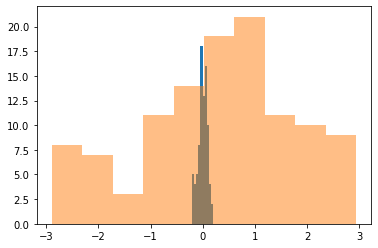

In [8]:
track0 = mixed_data.loc[mixed_data['track_id']==1]
X = np.array([track0['X'], track0['Y']]).T
s = np.array(track0['s'])
l, alpha = convert_to_planar(X,dt)
s = s[1:-1]
straight = (s == 1)
brown = (s == 0)
plt.hist(alpha[straight])
plt.hist(alpha[brown],alpha=0.5)

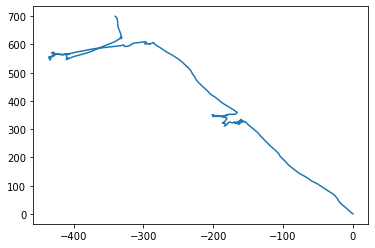

In [9]:
plt.plot(X[:,0], X[:,1])

In [10]:
l_s1 = []
l_s2 = []
alpha_s1 = []
alpha_s2 = []

for tr in np.unique(mixed_data['track_id']):
    track0 = mixed_data.loc[mixed_data['track_id']==tr]
    X = np.array([track0['X'], track0['Y']]).T
    s = np.array(track0['s'])
    l, alpha = convert_to_planar(X,dt)
    s = s[1:-1]
    straight = (s == 1)
    brown = (s == 0)
    l_s2.append(l[straight])
    l_s1.append(l[brown])
    alpha_s1.append(alpha[straight])
    alpha_s2.append(alpha[brown])
    
l_s1 = flatten_list(l_s1)
l_s2 = flatten_list(l_s2)
alpha_s1 = flatten_list(alpha_s1)
alpha_s2 = flatten_list(alpha_s2)


/home/svensson/anaconda3/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'll' of function 'flatten_list'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Peroxisome_HMM.py", line 10:
@jit(nopython=True)
def flatten_list(ll):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


(array([ 572.,  677.,  860., 1286., 1744., 1724., 1245.,  873.,  622.,
         559.]),
 array([-3.14088776e+00, -2.51305283e+00, -1.88521789e+00, -1.25738296e+00,
        -6.29548031e-01, -1.71309927e-03,  6.26121833e-01,  1.25395676e+00,
         1.88179170e+00,  2.50962663e+00,  3.13746156e+00]),
 <BarContainer object of 10 artists>)

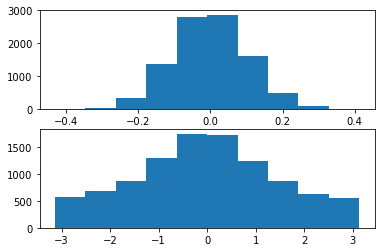

In [11]:
plt.subplot(2,1,1)
plt.hist(alpha_s1)
plt.subplot(2,1,2)
plt.hist(alpha_s2)

(array([   3.,   51.,  318., 1188., 2429., 2836., 1924.,  718.,  147.,
          24.]),
 array([ 4.3266565 ,  5.41110106,  6.49554563,  7.57999019,  8.66443475,
         9.74887931, 10.83332388, 11.91776844, 13.002213  , 14.08665757,
        15.17110213]),
 <BarContainer object of 10 artists>)

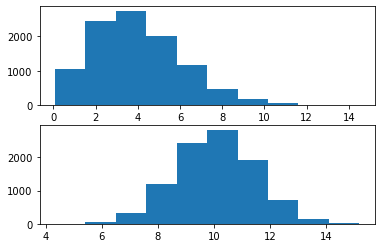

In [12]:
plt.subplot(2,1,1)
plt.hist(l_s1)
plt.subplot(2,1,2)
plt.hist(l_s2)

[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


([], [])

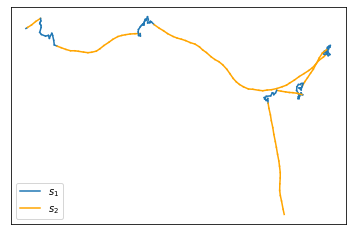

In [13]:
c1 = '#1f77b4'
c2 = 'orange'
track0 = mixed_data.loc[mixed_data['track_id']==0]
#plt.plot(track0['X'].iloc[0:], track0['Y'].iloc[0:])
s_est = np.array(track0['s'])
lab1=True
lab2=True
print(s_est)
for ii in range(track0['X'].shape[0]-2):
    if s_est[ii+1] == 0:
        if lab1:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c1, label=r'$s_1$')
            lab1=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c1)
    else:
        if lab2:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c2, label=r'$s_2$')
            lab2=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c2)
        #print(o[ii])
plt.legend()
plt.xticks([])
plt.yticks([])

In [14]:
res_dic = {}
counter = 0
for tr in np.unique(mixed_data['track_id']):
    track0 = mixed_data.loc[mixed_data['track_id']==tr]
    Tm = np.array([[0.95, 0.05],[0.3, 0.7]]) 
    pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
    mu_l = np.array([-1.11, 0.5])
    sigma_l = np.array([0.75, 0.75])
    sigma_alpha_2 = 0.45
    
    X = np.array([track0['X'], track0['Y']]).T
    dt = track0['t'].iloc[1]-track0['t'].iloc[0]
    l, alpha = convert_to_planar(X,dt)
    #print(alpha.shape)
    o = np.array([l[:], alpha]).T
    o_log = np.copy(o[:])
    o_log[:,0] = np.log(o[:,0])
    run_dic = {"track_id" : str(tr)}
    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], Tm, pi, mu_l, sigma_l, sigma_alpha_2, fit_mu=True, fit_sigma=True)
    converged = False
    iters = 0
    while not converged and iters < 1000:
        iters += 1
        mu_l_old = np.copy(mu_l_new)
        sigma_l_old = np.copy(sigma_l_new)
        pi_old = np.copy(pi_new)
        T_old = np.copy(T_new)
        mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new, fit_mu=True, fit_sigma=True)
        diff_m = mu_l_new - mu_l_old
        diff_s = sigma_l_new - sigma_l_old
        diff_p = pi_old - pi_new
        diff_T = T_old - T_new
        d_vector = [np.sqrt(diff_m.dot(diff_m)), 
                    np.sqrt(diff_s.dot(diff_s)), 
                    np.sqrt(diff_p.dot(diff_p)), 
                    np.linalg.norm(diff_T)]
        #print(np.max(d_vector))
        if np.max(d_vector) < 0.001:
            converged = True

    run_dic["mu_l"] = np.copy(mu_l_new[:])
    run_dic["sigma_l"] = np.copy(sigma_l_new[:])
    run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
    run_dic["T"] = np.copy(T_new[:])
    run_dic["pi"] = np.copy(pi_new[:])
    res_dic[counter] = run_dic
    counter += 1
    
with open("./Simulated_data/params_mixed_data.json", "w") as write_file:
    json.dump(res_dic, write_file, cls=NumpyArrayEncoder)

In [15]:
mu = []
T = []
pi = []
sigma = []
for key in res_dic.keys():
    mu.append(res_dic[key]['mu_l'])
    pi.append(res_dic[key]['pi'])
    T.append(res_dic[key]['T'])
    sigma.append(res_dic[key]['sigma_l'])
    
mu = np.array(mu)
T = np.array(T)
pi = np.array(pi)
sigma = np.array(sigma)

In [16]:
res_dic[0]

{'track_id': '0',
 'mu_l': array([1.14841915, 2.27501759]),
 'sigma_l': array([0.64570724, 0.14121574]),
 'sigma_alpha_2': array(0.45),
 'T': array([[0.91618924, 0.08381076],
        [0.06623472, 0.93376528]]),
 'pi': array([0.50479536, 0.49520464])}

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff1eaa40e90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff1ea9add50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff1eaa40910>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff1eaa94ad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff1eaa941d0>,
 'means': []}

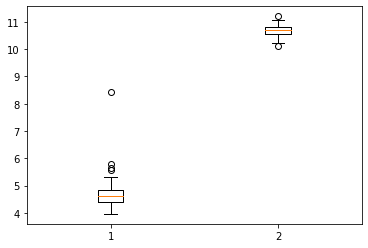

In [17]:
plt.boxplot(np.exp(mu+sigma/2))

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff20c658190>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff1ea9b6150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff20c658250>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff1ea9b6d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff20c72ddd0>,
 'means': []}

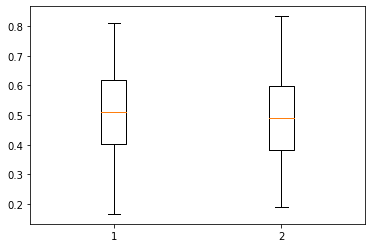

In [18]:
plt.boxplot(pi)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff1eba76a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff1eb9ffd10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff1eba765d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff1eb9ff350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff1eb470090>,
 'means': []}

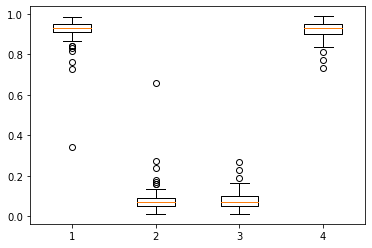

In [19]:
T.shape
plt.boxplot(T.reshape(100,4))

In [20]:
res_dic[1]

{'track_id': '1',
 'mu_l': array([1.30307556, 2.33128883]),
 'sigma_l': array([0.56108833, 0.12672876]),
 'sigma_alpha_2': array(0.45),
 'T': array([[0.9504473 , 0.0495527 ],
        [0.08399285, 0.91600715]]),
 'pi': array([0.56356806, 0.43643194])}

0.026363636363636363
[95, 83, 52, 65, 76, 129, 37, 59, 79, 38, 99, 102, 128, 82, 128, 111, 110, 95, 54, 116, 114, 123, 100, 21, 109, 64, 71, 77, 126, 109, 124, 93, 65, 70, 104, 96, 81, 124, 104, 53, 104, 116, 116, 123, 86, 109, 33, 125, 46, 121, 92, 88, 93, 73, 66, 77, 77, 120, 100, 90, 138, 150, 68, 103, 62, 171, 84, 62, 105, 50, 89, 125, 40, 127, 75, 66, 71, 161, 72, 71, 32, 41, 97, 168, 124, 119, 100, 137, 123, 66, 107, 95, 75, 45, 101, 137, 123, 87, 125, 91]


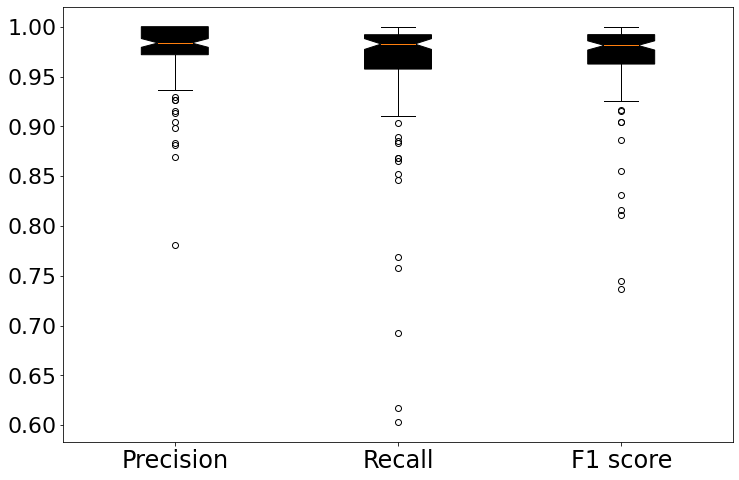

In [58]:
err = []
TP = []
FP = [] 
FN = []
for ii in np.unique(mixed_data['track_id']):
    track0 = mixed_data.loc[mixed_data['track_id']==ii]
    X = np.array([track0['X'], track0['Y']]).T
    dt = track0['t'].iloc[1]-track0['t'].iloc[0]
    l, alpha = convert_to_planar(X,dt)
    T = res_dic[ii]['T']
    mu = res_dic[ii]['mu_l']
    sigma = res_dic[ii]['sigma_l']
    pi = res_dic[ii]['pi']
    o = np.array([l[:], alpha]).T
    s_est, D, E = viterbi(T, pi, mu, sigma, 0.45, o)
    err.append(sum(abs(track0['s'].iloc[1:-1] - s_est))/s_est.shape[0])
    st = track0['s'].iloc[1:-1]
    TP.append(np.sum(np.array((st==1))*np.array((s_est==1))))
    FP.append(np.sum(np.array((st==0))*np.array((s_est==1))))
    FN.append(np.sum(np.array((st==1))*np.array((s_est==0))))

precision = np.array(TP)/(np.array(TP)+np.array(FP))
recall = np.array(TP)/(np.array(TP)+np.array(FN))
fig = plt.figure(figsize=(12,8))

pos = np.array([1, 3])
width = 0.2
box1 = plt.boxplot([ precision, recall, 2*(precision*recall)/(precision+recall)], patch_artist=True, notch=True)
#box2 = plt.boxplot(recall, positions=pos-2*width, widths=width, patch_artist=True, notch=True)
#box3 = plt.boxplot(precision, positions=pos-width, widths=width, patch_artist=True, notch=True)

colors = ['black', 'black', 'black']
#box1 = plt.boxplot(1-err, patch_artist=True, notch=True)
for p1, c in zip(box1['boxes'], colors):
    p1.set_facecolor(c)
    
plt.ylabel('', size=24)
plt.xticks([1,2,3], ['Precision', 'Recall', 'F1 score'], size=24)
plt.yticks(size=22)

print(np.mean(err))
print(TP)
plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Manuscript/error_box.svg')

In [49]:
np.array(st).shape

(198,)

In [29]:
track0 = mixed_data.loc[mixed_data['track_id']==0]
dt = track0['t'].iloc[1]-track0['t'].iloc[0]
l, alpha = convert_to_planar(X,dt)
T = res_dic[0]['T']
mu = res_dic[0]['mu_l']
sigma = res_dic[0]['sigma_l']
pi = res_dic[0]['pi']
o = np.array([l[:], alpha]).T
print(pi)
s_est, D, E = viterbi(T, pi, mu, sigma, 0.45, o)

[0.50479536 0.49520464]


[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0]


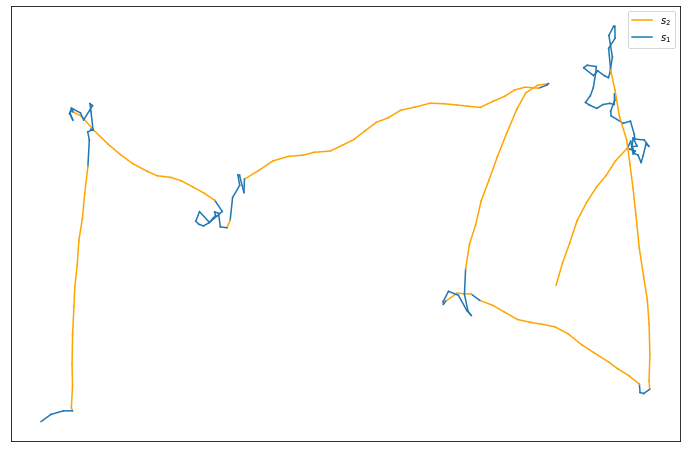

In [33]:
fig = plt.figure(figsize=(12,8))
c1 = '#1f77b4'
c2 = 'orange'
#track0 = mixed_data.loc[mixed_data['track_id']==0]
#plt.plot(track0['X'].iloc[0:], track0['Y'].iloc[0:])
#s_est = np.array(track0['s'])
lab1=True
lab2=True
print(s_est)
for ii in range(track0['X'].shape[0]-3):
    if s_est[ii] == 0:
        if lab1:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1, label=r'$s_1$')
            lab1=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1)
    else:
        if lab2:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2, label=r'$s_2$')
            lab2=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2)
        #print(o[ii])
plt.legend()
plt.xticks([])
plt.yticks([])
#plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Plots/simulated_track_1_Viterbi_fitted.svg')
plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Manuscript/simulated_track_1_Viterbi_fitted.svg')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1.]


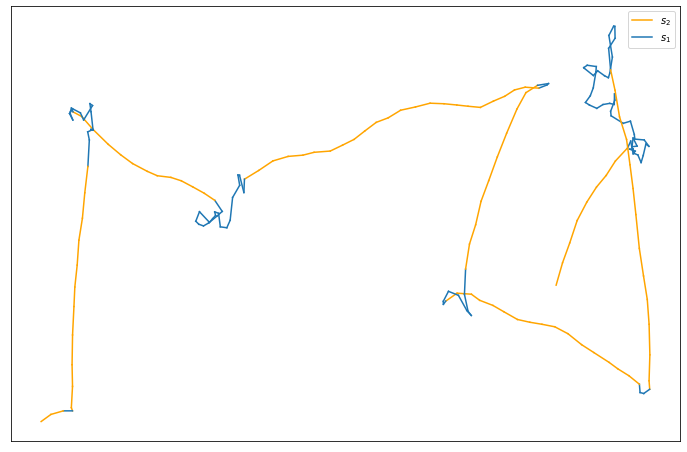

In [35]:
c1 = '#1f77b4'
c2 = 'orange'
fig = plt.figure(figsize=(12,8))
#track0 = mixed_data.loc[mixed_data['track_id']==0]
#plt.plot(track0['X'].iloc[0:], track0['Y'].iloc[0:])
#s_est = np.array(track0['s'])
lab1=True
lab2=True
s = np.array(track0['s'])
print(s)
for ii in range(track0['X'].shape[0]-3):
    if s[ii+1] == 0:
        if lab1:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1, label=r'$s_1$')
            lab1=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1)
    else:
        if lab2:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2, label=r'$s_2$')
            lab2=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2)
        #print(o[ii])
plt.legend()
plt.xticks([])
plt.yticks([])
#plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Plots/simulated_track_1_GT.svg')
plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Manuscript/simulated_track_1_GT.svg')

In [25]:
X = np.array([track0['X'], track0['Y']]).T
dt = track0['t'].iloc[1]-track0['t'].iloc[0]
l, alpha = convert_to_planar(X,dt)

print(l)

[ 9.95732493  9.38122669 10.30277833  9.23454502  9.56785979  9.38986061
  8.68940958  8.80348931 13.38073104  8.66654698 13.10193036 12.18110701
  9.63629186 12.41530193  9.42622729 10.40745547 11.03165623  9.72991152
  9.8534769  11.95995357 12.47696888 12.26367014  8.87188967  9.72203261
 10.6324676   8.26980256 10.4725336  10.55853969  8.65928145 10.21647869
 10.40444447 10.61156746 11.26857849  9.1385053   3.00894592  8.16146871
  3.70470588  6.21367605  4.24606379  4.4744253   1.18387345  5.06532981
  2.86808847  0.94210241  5.05335022  6.29071201  1.86914774  1.34282414
  2.40346115  2.71914399  2.30940347  3.90841858  2.9510327   3.42477893
  4.67386085  4.75843605  6.89791945  4.13358054  4.8456469   3.93341911
  3.35023673  5.84912729  3.8927547   6.49340676  4.89261314  3.18969122
  2.10032485  6.00767548 10.04780665  3.5355529   4.12594535  6.39913729
  4.13298887  5.06658764  1.60970893  4.18870965  2.72016206  6.01864506
  5.30270598  4.49300712  7.39411422  1.1766001   4